In [1]:
import QuantLib as ql

In [2]:
import csv
import os
from typing import List, Tuple
import numpy
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.ticker import StrMethodFormatter


def read_swap_quotes(date) -> List[ql.RelinkableQuoteHandle]:
    root_dir = os.getcwd()
    date_as_int = date.year() * 10000 + date.month() * 100 + date.dayOfMonth()
    file_name = 'swap_rates_' + str(date_as_int) + '.csv'
    file_path = os.path.join(root_dir, 'data/', file_name)
    with open(file_path, 'rt') as file:
        reader = csv.reader(file, delimiter=',')
        rates = [(ql.PeriodParser.parse(str(r[0])), float(r[1])) for r in reader]
        return [(q[0], ql.RelinkableQuoteHandle(ql.SimpleQuote(q[1]))) for q in rates]


def read_liabilities() -> List[Tuple[ql.Date, float]]:
    root_dir = os.getcwd()
    file_name = 'liabilities.csv'
    file_path = os.path.join(root_dir, 'data/', file_name)
    with open(file_path, 'rt') as file:
        reader = csv.reader(file, delimiter=',')
        return [(ql.Date(str(r[0]), '%Y%m%d'), float(r[1])) for r in reader]
    

def calculate_last_liquid_forward(crv: ql.YieldTermStructureHandle, fsp: ql.Period):
    d_counter = crv.dayCounter()
    reference_date = crv.referenceDate()
    omega = 8.0 / 15.0
    fsp_date = reference_date + fsp
    llfr_weights = ((ql.Period(25, ql.Years), 1.0), 
                    (ql.Period(30, ql.Years), 0.5), 
                    (ql.Period(40, ql.Years), 0.25), 
                    (ql.Period(50, ql.Years), 0.125))
    llfr = 0.0
    for tenor, weight in llfr_weights:
        llfr += weight * crv.forwardRate(fsp_date, reference_date + tenor, d_counter, ql.Continuous).rate()
    return llfr


def bump_quote(quote_handle: ql.RelinkableQuoteHandle, bump = 0.0001):
    quote_handle.linkTo(ql.SimpleQuote(quote_handle.value() + bump))

    
def liabilities_pricer(discount_handle: ql.YieldTermStructureHandle):
    
    def value(cash_flows: List[Tuple[ql.Date, float]]) -> float:
        return sum([discount_handle.discount(dt) * amount for dt, amount in cash_flows])

    return value


def zero_rates(curve_handle: ql.YieldTermStructureHandle, tenors: List[ql.Period]) -> List[Tuple[float, float]]:
    reference_date = curve_handle.referenceDate()
    d_counter = curve_handle.dayCounter()
    dates = [reference_date + tnr for tnr in tenors]
    t = [curve_handle.timeFromReference(d) for d in dates]
    z = [curve_handle.zeroRate(d, d_counter, ql.Continuous, ql.NoFrequency).rate() for d in dates]
    return list(zip(t, z))


def plot_zero_curve(curve_handle: ql.YieldTermStructureHandle, tenors: List[ql.Period], title):
    t, z = zip(*zero_rates(curve_handle, tenors))
    fig, ax = plt.subplots()
    ax.plot(t, z)
    ax.set(xlabel='time', ylabel='zero', title=title)
    ax.grid()
    plt.show()

In [3]:
# SWAP INDEX CONVENTIONS

SETTLEMENT_DAYS = 2
BUSINESS_CONVENTION = ql.Unadjusted
DAY_COUNT = ql.SimpleDayCounter()
CALENDAR = ql.NullCalendar()
CCY = ql.EURCurrency()
FXD_FREQUENCY = ql.Annual
FLT_TENOR = ql.Period(6, ql.Months)


# FTK CURVE CONSTRUCTION FUNCTION

def build_ftk_curve(valuation_date: ql.Date, quote_handles: List[ql.QuoteHandle]):
    idx = ql.IborIndex("FTK_IDX", FLT_TENOR, SETTLEMENT_DAYS, CCY, CALENDAR, BUSINESS_CONVENTION, False, DAY_COUNT)
    settlement = CALENDAR.advance(today, SETTLEMENT_DAYS, ql.Days)
    instruments = [ql.SwapRateHelper(q, t, CALENDAR, FXD_FREQUENCY, BUSINESS_CONVENTION, DAY_COUNT, idx) 
                   for t, q in quote_handles]
    crv = ql.PiecewiseLogLinearDiscount(settlement, instruments, DAY_COUNT)
    crv.enableExtrapolation()
    return crv


In [4]:
# UFR CONVENTIONS

FIRST_SMOOTHING_POINT = ql.Period(20, ql.Years)
ALPHA = 0.1;

ufr_compounded = ql.InterestRate(0.023, DAY_COUNT, ql.Compounded, ql.Annual)
ufr_continuous = ufr_compounded.equivalentRate(ql.Continuous, ql.Annual, 1.0).rate()

In [5]:
# VALUATION DATE

today = CALENDAR.adjust(ql.Date(29, ql.March, 2019))
ql.Settings.instance().evaluationDate = today


# READ SWAP RATES

swap_quotes = read_swap_quotes(today)

# UFR CURVE 2015 CONSTRUCTION
    
ftk_handle = ql.RelinkableYieldTermStructureHandle()
llfr_handle = ql.RelinkableQuoteHandle()
ufr_handle = ql.QuoteHandle(ql.SimpleQuote(ufr_continuous))

def update_llfr_handle():
    llfr = calculate_last_liquid_forward(ftk_handle, FIRST_SMOOTHING_POINT)
    llfr_handle.linkTo(ql.SimpleQuote(llfr))
    

llfr_observer = ql.Observer(update_llfr_handle)
for _, quote_handle in swap_quotes:
    llfr_observer.registerWith(quote_handle)

ftk_handle.linkTo(build_ftk_curve(today, swap_quotes))
update_llfr_handle()
ufr_crv = ql.UltimateForwardTermStructure(ftk_handle, llfr_handle, ufr_handle, FIRST_SMOOTHING_POINT, ALPHA)
ufr_crv.enableExtrapolation()

ufr_handle = ql.YieldTermStructureHandle(ufr_crv)

In [6]:
liabilities = read_liabilities()

ftk_pricer = liabilities_pricer(ftk_handle)
ufr_pricer = liabilities_pricer(ufr_handle)

npv_ftk = ftk_pricer(liabilities)
print('FTK NPV ', npv_ftk)

npv_ufr = ufr_pricer(liabilities)
print('UFR NPV ', npv_ufr)

FTK NPV  10850150959.77744
UFR NPV  10115915288.111174


In [7]:
BUMP = 1.0e-4
SCALING = 1.0e-4

ftk_sensitivities = []
ufr_sensitivities = []


for tenor, quote in swap_quotes:  
    bump_quote(quote, BUMP)
    ftk_sensitivities.append((tenor , (ftk_pricer(liabilities) - npv_ftk) / BUMP * SCALING))
    ufr_sensitivities.append((tenor , (ufr_pricer(liabilities) - npv_ufr) / BUMP * SCALING))
    
    bump_quote(quote, -BUMP)

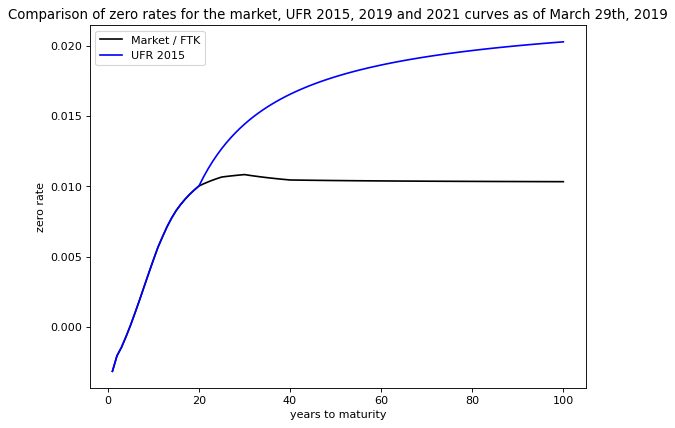

In [8]:
tenors = [ql.PeriodParser.parse(str(i) + 'y') for i in range(1, 101)]

figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.title(f'Comparison of zero rates for the market, UFR 2015, 2019 and 2021 curves as of {today}')
plt.xlabel('years to maturity')
plt.ylabel('zero rate')

t, ftk_zeroes = zip(*zero_rates(ftk_handle, tenors))
plt.plot(t, ftk_zeroes, "-k", label="Market / FTK")

_, ufr_zeroes = zip(*zero_rates(ufr_handle, tenors))
plt.plot(t, ufr_zeroes, "-b", label="UFR 2015")

plt.legend(loc="upper left")
plt.show()

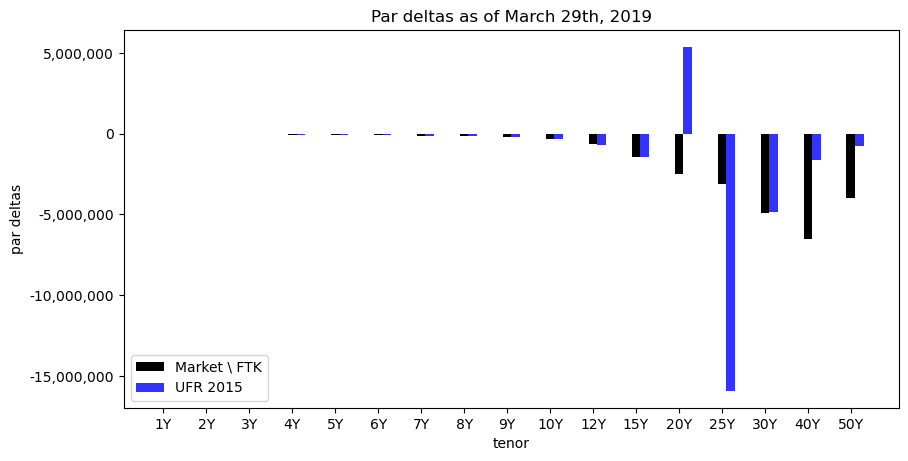

In [9]:
plt.figure(num=None, figsize=(10, 5), dpi=100, facecolor='w', edgecolor='k')
width = 0.2

title=f'Par deltas as of {today}'
plt.title(title)

grid, ftk_deltas = zip(*ftk_sensitivities)
grid_str = [str(tnr) for tnr in grid]
y_pos = numpy.arange(len(grid_str))
plt.bar(y_pos, ftk_deltas, width, color='k', label="Market \ FTK")

grid, ufr_deltas = zip(*ufr_sensitivities)
grid_str = [str(tnr) for tnr in grid]
y_pos = numpy.arange(len(grid_str))
plt.bar(y_pos + width, ufr_deltas, width, alpha=0.8, color='b', label="UFR 2015")

plt.xticks(y_pos, grid_str)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) # No decimal places
plt.xlabel('tenor')
plt.ylabel('par deltas')
plt.legend(loc="lower left")
plt.show()

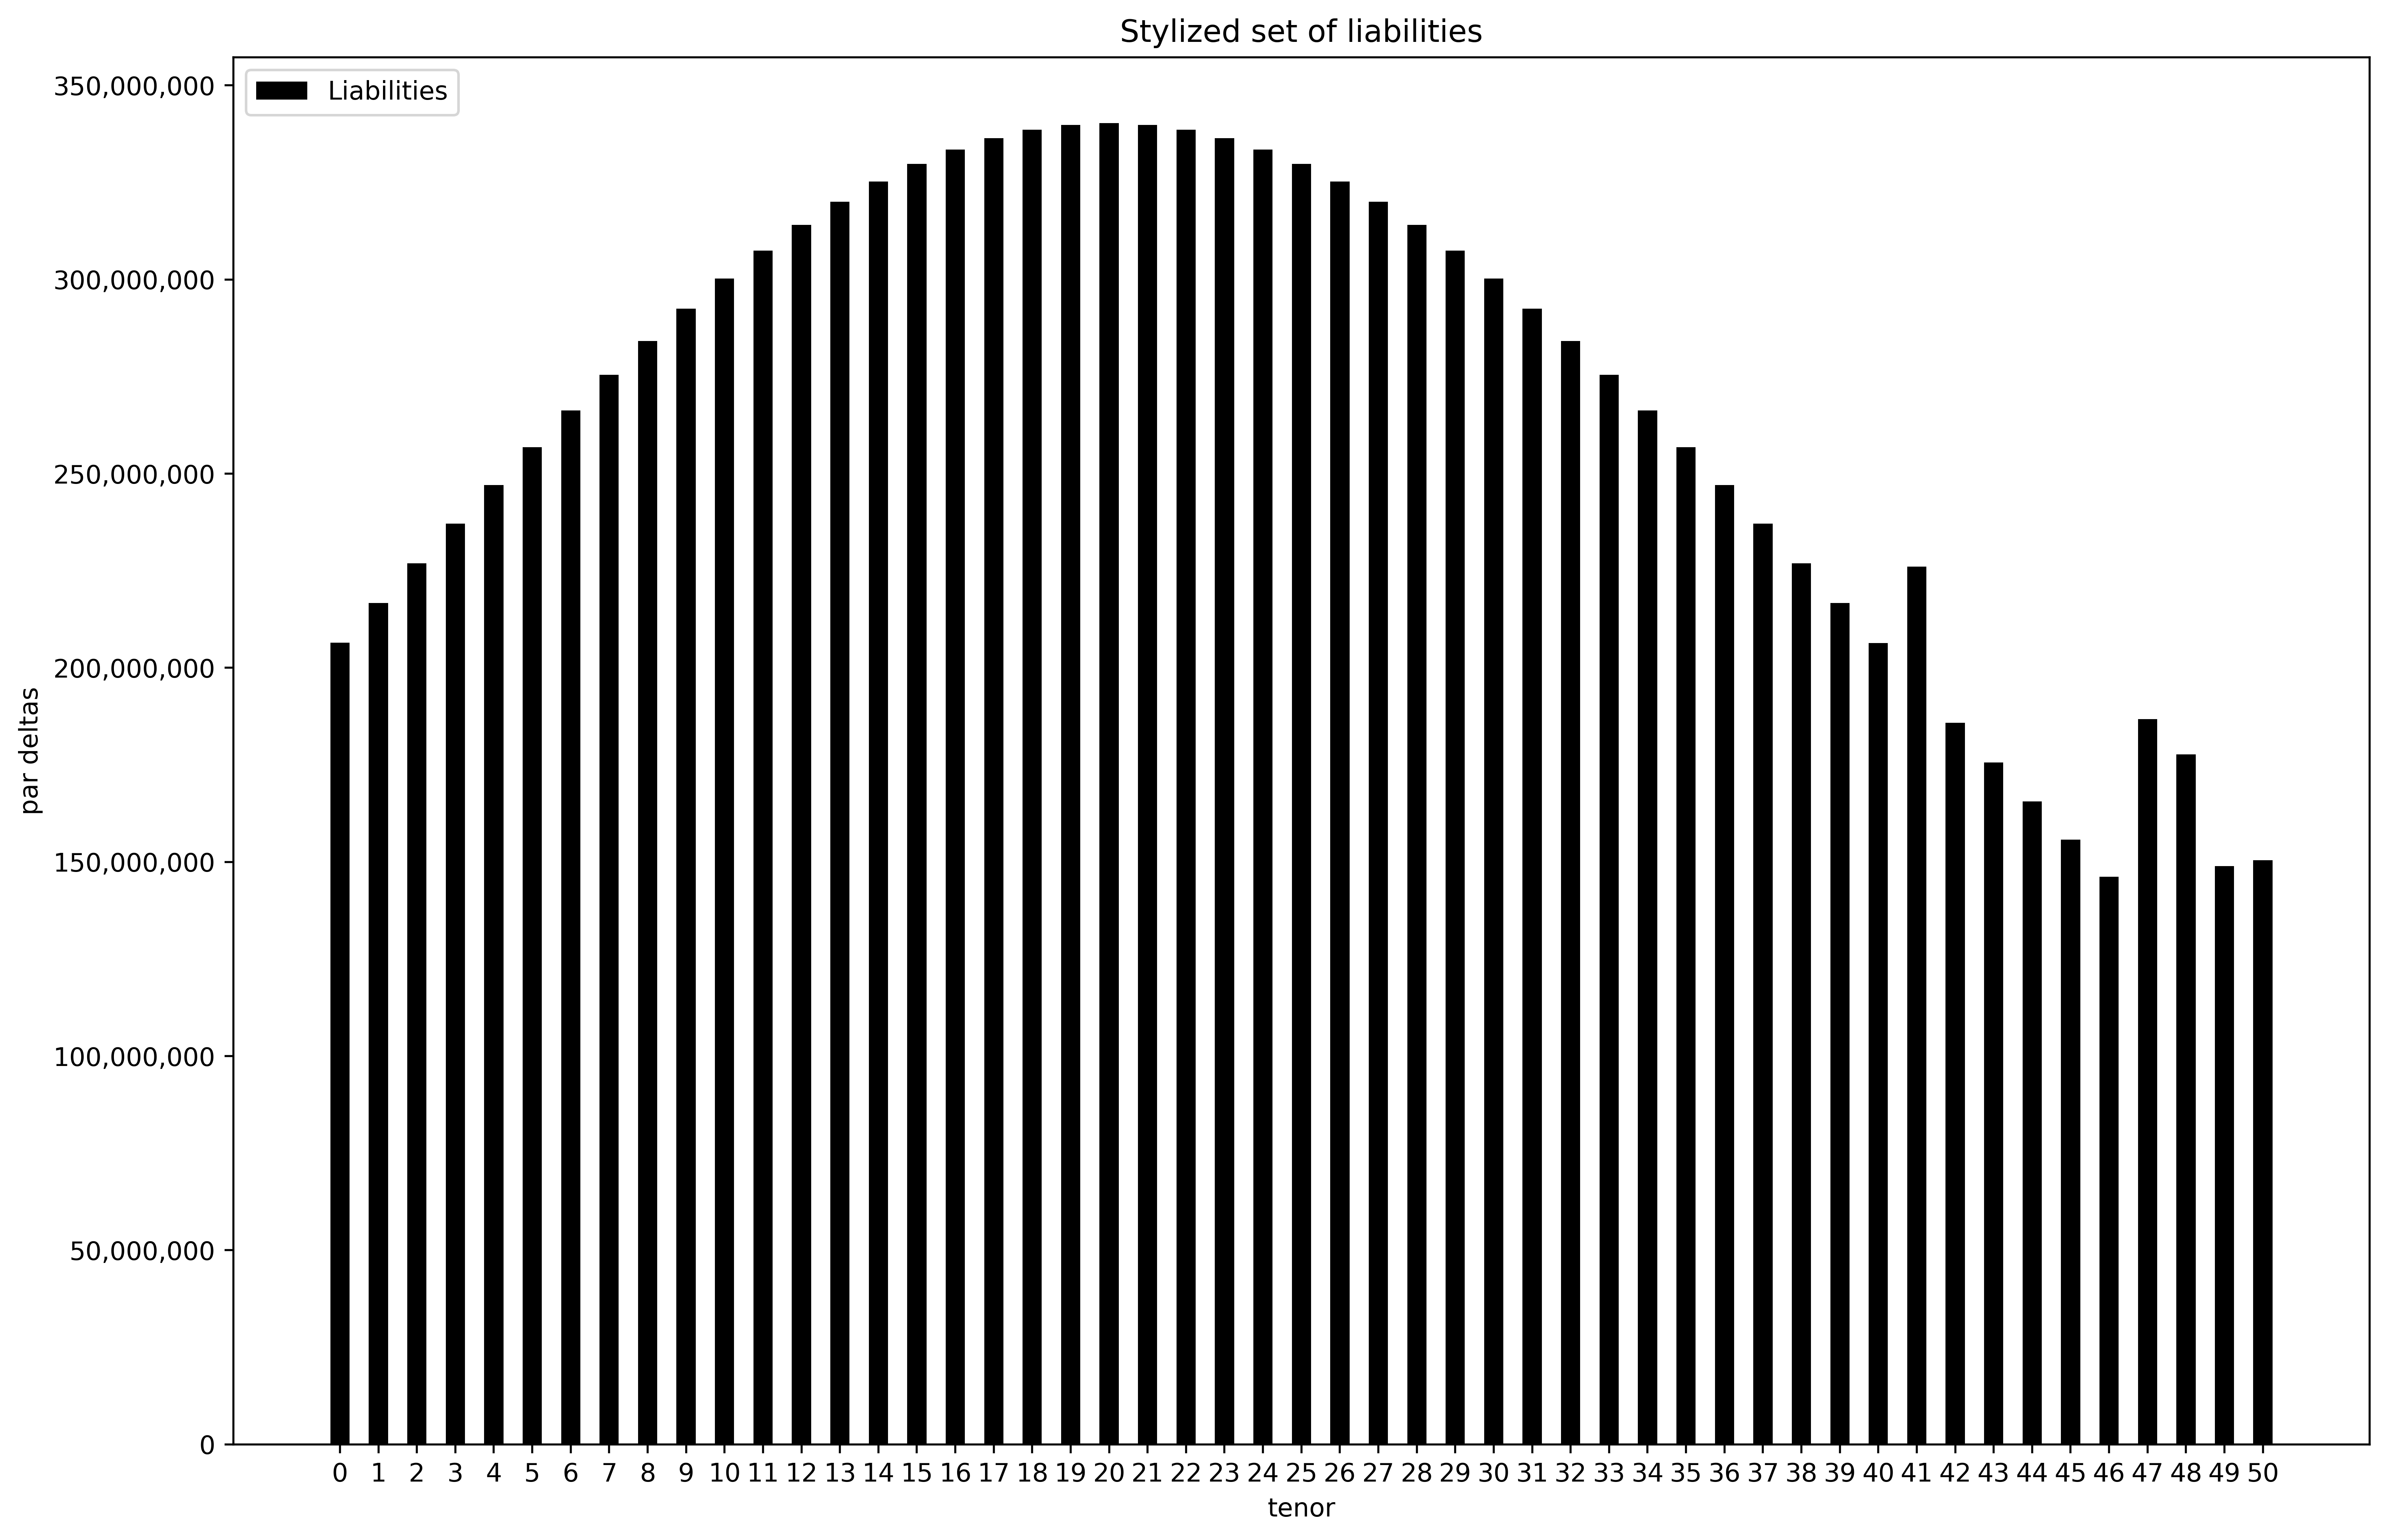

In [10]:
plt.figure(num=None, figsize=(15, 10), dpi=500, facecolor='w', edgecolor='k')
width = 0.5

title=f'Stylized set of liabilities'
plt.title(title)

maturities, flows = zip(*liabilities)
y_pos = numpy.arange(len(maturities))
plt.bar(y_pos, flows, width, color='k', label="Liabilities")

times = [int(ftk_handle.timeFromReference(d)) for d in maturities]
plt.xticks(y_pos, times)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) # No decimal places
plt.xlabel('tenor')
plt.ylabel('par deltas')
plt.legend(loc="upper left")
plt.show()